In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [8]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
# Extract data and labels from the dataset
data = []
labels = []

for images, labels_batch in dataset:
    data.append(images.numpy())
    labels.append(labels_batch.numpy())

data = np.concatenate(data)
labels = np.concatenate(labels)


In [14]:
# Define class names
class_names = dataset.class_names

In [11]:
# Split dataset into train, validation, and test sets
train_data, test_val_data, train_labels, test_val_labels = train_test_split(
    data, labels, train_size=train_size, test_size=val_size+test_size, random_state=42
)
val_data, test_data, val_labels, test_labels = train_test_split(
    test_val_data, test_val_labels, 
    train_size=val_size/(val_size+test_size), 
    test_size=test_size/(val_size+test_size), 
    random_state=42
)

In [12]:
# Data augmentation and preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
# Model building
base_model = tf.keras.applications.ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                            include_top=False,
                                            weights='imagenet')

base_model.trainable = False

inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = resize_and_rescale(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [16]:
# Model compilation
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [17]:
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 64)                131136    
                                                             

In [18]:
# Model training
history = model.fit(
    train_data, train_labels,
    batch_size=BATCH_SIZE,
    validation_data=(val_data, val_labels),
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50


54/54 [==============================] - 75s 1s/step - loss: 0.9140 - accuracy: 0.4951 - val_loss: 0.8010 - val_accuracy: 0.6233
Epoch 2/50
54/54 [==============================] - 68s 1s/step - loss: 0.7977 - accuracy: 0.6467 - val_loss: 0.7895 - val_accuracy: 0.5767
Epoch 3/50
54/54 [==============================] - 69s 1s/step - loss: 0.7684 - accuracy: 0.6845 - val_loss: 0.7530 - val_accuracy: 0.6233
Epoch 4/50
54/54 [==============================] - 70s 1s/step - loss: 0.7278 - accuracy: 0.6909 - val_loss: 0.6350 - val_accuracy: 0.7860
Epoch 5/50
54/54 [==============================] - 69s 1s/step - loss: 0.6736 - accuracy: 0.7484 - val_loss: 0.5943 - val_accuracy: 0.8000
Epoch 6/50
54/54 [==============================] - 68s 1s/step - loss: 0.6616 - accuracy: 0.7368 - val_loss: 0.6121 - val_accuracy: 0.7628
Epoch 7/50
54/54 [==============================] - 69s 1s/step - loss: 0.6361 - accuracy: 0.7577 - val_loss: 0.5518 - val_accuracy: 0.8093
Epoch 8/50
54/54 [

In [19]:
# Model evaluation
scores = model.evaluate(test_data, test_labels)

print("Test Accuracy:", scores[1])

7/7 [==============================] - 8s 1s/step - loss: 0.3899 - accuracy: 0.8519
Test Accuracy: 0.8518518805503845


7/7 [==============================] - 9s 1s/step


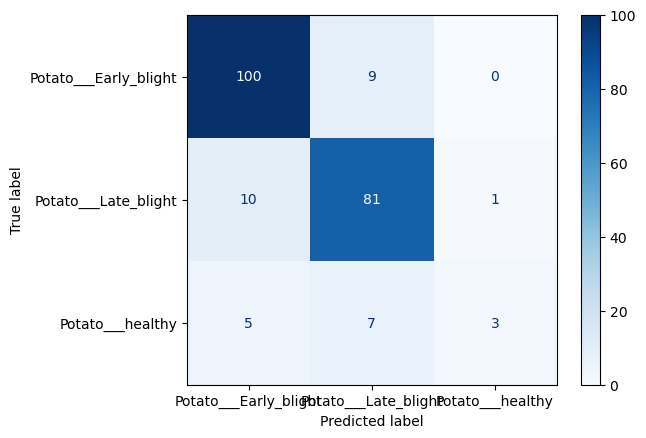

In [20]:
# Confusion matrix
y_pred = model.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

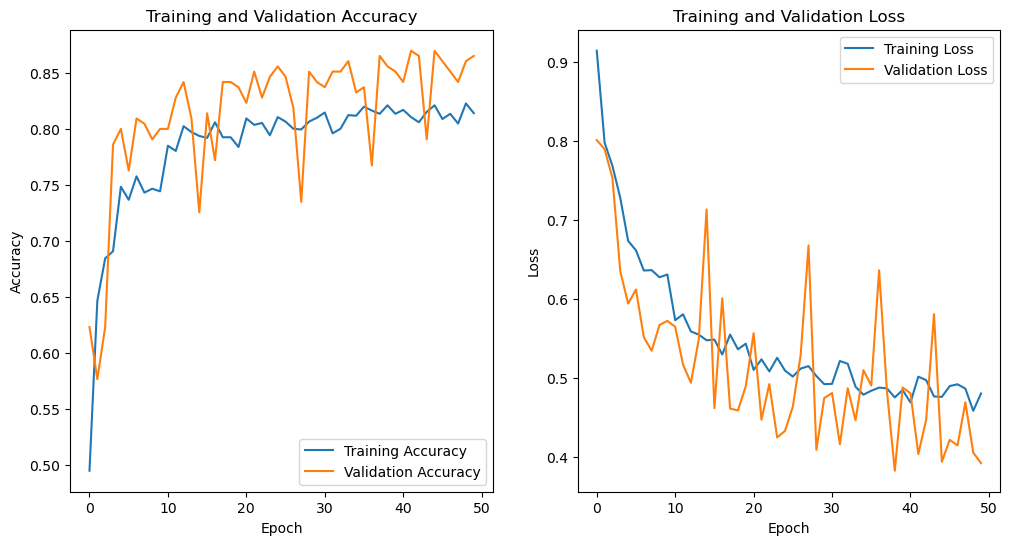

In [21]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()